# Stochastic Models in Finance: TP6
By: 
- Adonis JAMAL
- Ayoub EL KBADI
- Fotios KAPOTOS

In [1]:
import numpy as np
import math
from scipy.stats import norm
from matplotlib import pyplot as plt

In [2]:
# Model values
S0 = 100        # initial stock price
K = 100         # strike price
T = 2.0         # time to maturity in years
r = 0.05        # risk-free rate
sigma = 0.2     # volatility
lam = 2         # jump intensity
mu_J = -0.02    # jump mean
sigma_J = 0.2   # jump volatility

1. Formule de pricing explicite du prix du call dans le modèle avec sauts

Conditionellement au nombre de sauts $N_t = j$, le log-rendement suit une loi normale.

Le prix du call est la somme pondérée des espérances conditionnelles: $$C(S_0, K, T) = \sum_{j=0}^{\infty} \mathbb{P}(N_T = j) \times \mathbb{E}\left[(S_T - K)_+ | N_T = j\right]$$

Sous l'hypothèse de sauts log-normaux où $\log (1 + Y_i) \sim \mathcal{N}(\mu_J, \sigma_J^2)$, le prix $S_T$ conditionné à $j$ sauts se comporte comme dans le modèle de Black-Scholes avec une volatilité et un taux sans risque ajustés: $$C(S_0, K, T) = \sum_{j=0}^{\infty} e^{-\tilde{\lambda} T} \frac{(\tilde{\lambda} T)}{j!} \times C_{BS}(S_0, K, T, r_j, \sigma_j)$$ où $C_{BS}$ est la formule de Black-Scholes, avec les paramètres ajustés pour chaque terme $j$: $$r_j = r - \tilde{\lambda} \tilde{\beta} + \frac{j (\mu_J + \frac{\sigma_J^2}{2})}{T} \quad \text{avec} \quad \tilde{\beta} = \mathbb{E}^{\mathbb{Q}}[Y_1] = e^{\mu_J + \frac{\sigma_J^2}{2}} - 1$$ $$\sigma_j = \sqrt{\sigma^2 + \frac{j \sigma_J^2}{T}}$$

2. Convergence du prix en fonction du nombre de termes de la somme

In [3]:
def black_scholes_call(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def merton_jump_price(S, K, T, r, sigma, lam, mu_J, sigma_J, N_terms=50):
    price = 0.0
    price_history = [price]
    beta = np.exp(mu_J + 0.5 * sigma_J ** 2) - 1

    for j in range(N_terms):
        # Probability of j jumps
        prob_j = np.exp(-lam * T) * (lam * T) ** j / math.factorial(j)

        # Adjusted parameters for the j-th term
        sigma_j = np.sqrt(sigma ** 2 + (j * sigma_J ** 2) / T)
        r_j = r - lam * beta + (j * (mu_J + 0.5 * sigma_J ** 2)) / T

        # Black-Scholes price
        bs_price = black_scholes_call(S, K, T, r_j, sigma_j)
        price += prob_j * bs_price
        price_history.append(price)

    return price, price_history

Exact Merton Series Price: 23.3097


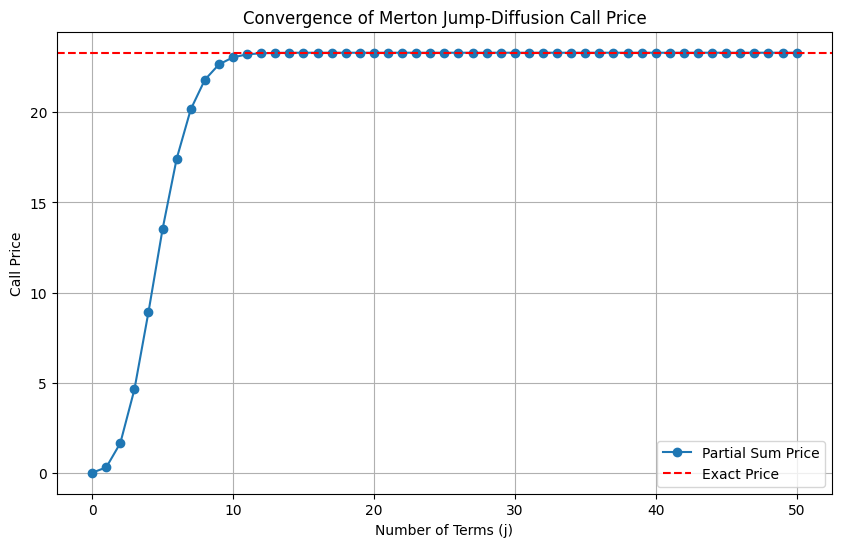

In [4]:
price, price_history = merton_jump_price(S0, K, T, r, sigma, lam, mu_J, sigma_J)
print(f"Exact Merton Series Price: {price:.4f}")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(price_history, marker='o', label='Partial Sum Price')
plt.axhline(y=price, color='r', linestyle='--', label='Exact Price')
plt.title('Convergence of Merton Jump-Diffusion Call Price')
plt.xlabel('Number of Terms (j)')
plt.ylabel('Call Price')
plt.legend()
plt.grid(True)
plt.show()

En observant le graphique, on constate que le prix de l'option converge rapidement lorsque le nombre de termes dans la somme augmente. Déjà à partir de $N=11$, le prix semble se stabiliser autour d'une valeur constante, indiquant que l'ajout de termes supplémentaires n'affecte plus significativement le résultat. Cela suggère que pour des calculs pratiques, il n'est pas nécessaire de sommer un grand nombre de termes pour obtenir une estimation précise du prix de l'option.

3. Pricing du prix du call dans le modèle avec sauts et convergence

In [5]:
def merton_mc_price(S0, K, T, r, sigma, lam, mu_J, sigma_J, N_simulations=10**4):
    dt = T
    beta = np.exp(mu_J + 0.5 * sigma_J**2) - 1

    # Simulate Poisson jumps
    N_jumps = np.random.poisson(lam * T, N_simulations)

    # Brownian motion
    Z = np.random.normal(0, 1, N_simulations)

    # Simulate sum of jumps
    J_mean = N_jumps * mu_J
    J_std = np.sqrt(N_jumps) * sigma_J
    sum_log_jumps = np.random.normal(J_mean, J_std)

    # Final stock price
    drift = (r - lam * beta - 0.5 * sigma**2) * T
    diffusion = sigma * np.sqrt(T) * Z
    S_T = S0 * np.exp(drift + diffusion + sum_log_jumps)

    # Payoff
    payoffs = np.exp(-r * T) * np.maximum(S_T - K, 0)

    price = np.mean(payoffs)
    std_err = np.std(payoffs) / np.sqrt(N_simulations)
    return price, std_err

In [6]:
mc_price, mc_err = merton_mc_price(S0, K, T, r, sigma, lam, mu_J, sigma_J)
print(f"Monte Carlo Merton Price: {mc_price:.4f} +/- {1.96 * mc_err:.4f} (95% CI)")
print(f"Absolute Error to Exact Price: {abs(mc_price - price):.4f}")

Monte Carlo Merton Price: 23.4540 +/- 0.8194 (95% CI)
Absolute Error to Exact Price: 0.1443


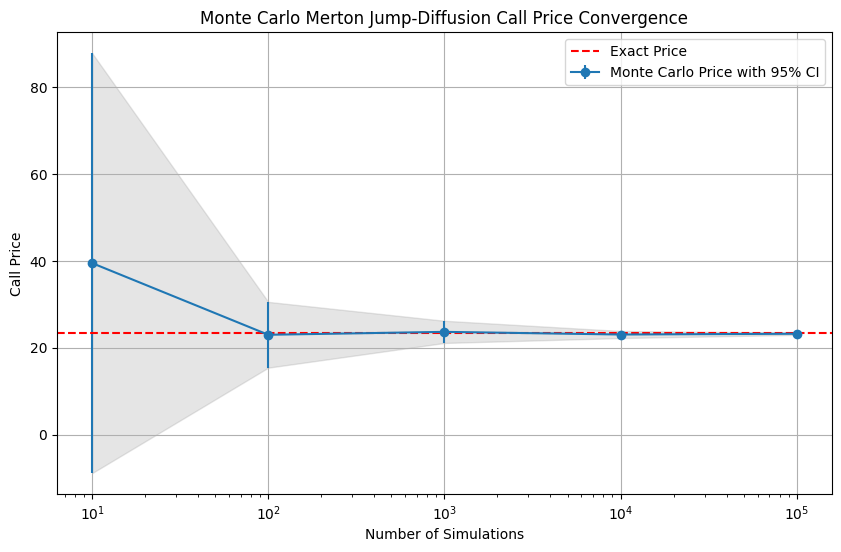

In [7]:
N_sims = [10, 10**2, 10**3, 10**4, 10**5]
mc_prices = []
mc_errors = []
for N in N_sims:
    p, err = merton_mc_price(S0, K, T, r, sigma, lam, mu_J, sigma_J, N)
    mc_prices.append(p)
    mc_errors.append(err)

# Plot
plt.figure(figsize=(10, 6))
plt.errorbar(N_sims, mc_prices, yerr=[1.96 * e for e in mc_errors], fmt='o-', label='Monte Carlo Price with 95% CI')
plt.fill_between(N_sims, 
                 [p - 1.96 * e for p, e in zip(mc_prices, mc_errors)],
                 [p + 1.96 * e for p, e in zip(mc_prices, mc_errors)],
                 color='gray', alpha=0.2)
plt.axhline(y=price, color='r', linestyle='--', label='Exact Price')
plt.xscale('log')
plt.title('Monte Carlo Merton Jump-Diffusion Call Price Convergence')
plt.xlabel('Number of Simulations')
plt.ylabel('Call Price')
plt.legend()
plt.grid(True)
plt.show()

On observe que le pricing du prix du call dans le modèle avec sauts converge bien vers le prix exact calculé précédemment. La méthode de Monte Carlo fournit une estimation précise du prix de l'option, avec un intervalle de confiance étroit, et avec un nombre relativement faible de simulations ($10^5$).

4. Smile de volatilité implicite engendré par le modèle à sauts

In [8]:
def implied_volatility_dichotomy(market_price, S, K, T, r, tol=1e-6, max_iter=100):
    # Initial bounds, avoid division by zero
    a, b = 0.0, 1.0 - 1e-6

    for _ in range(max_iter):
        x_mid = (a + b) / 2

        sigma_mid = x_mid / (1 - x_mid)

        # Black-Scholes price at mid volatility
        price_mid = black_scholes_call(S, K, T, r, sigma_mid)

        if price_mid < market_price: a = x_mid
        else: b = x_mid

        if abs(price_mid - market_price) < tol: return sigma_mid

    return (a + b) / 2 / (1 - (a + b) / 2)

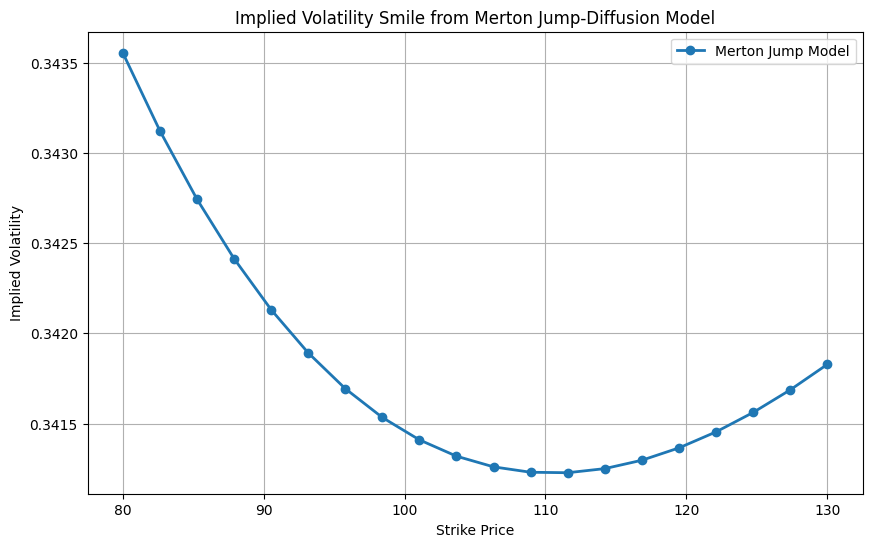

In [9]:
strikes = np.linspace(80, 130, 20)
implied_vols = []

for K_i in strikes:
    price_i, _ = merton_jump_price(S0, K_i, T, r, sigma, lam, mu_J, sigma_J)
    iv = implied_volatility_dichotomy(price_i, S0, K_i, T, r)
    implied_vols.append(iv)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(strikes, implied_vols, marker='o', linewidth=2, label='Merton Jump Model')
# plt.axhline(sigma, color='r', linestyle='--', label=f'Black-Scholes Volatility (Constant $\sigma={sigma}$)')
plt.title('Implied Volatility Smile from Merton Jump-Diffusion Model')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.legend()
plt.grid(True)
plt.show()

Contrairement au modèle de Black-Scholes, le modèle de Merton avec sauts génère un smile de volatilité implicite. On observe bien un smile de volatilité convexe, avec un skew négatif prononcé (la volatilité est plus forte pour les strikes faibles), indiquant que les options deep in-the-money et out-of-the-money ont des volatilités implicites plus élevées que les options at-the-money. Le marché paie plus cher pour se protéger contre la baisse extrême des actifs, ce qui est capturé par le modèle à sauts, et notamment contre les sauts négatifs modélisés par $\mu_j < 0$.

Pour $\mu_j = -0.02$, les sauts sont en moyenne négatifs, ce qui accentue le skew observé dans la volatilité implicite.

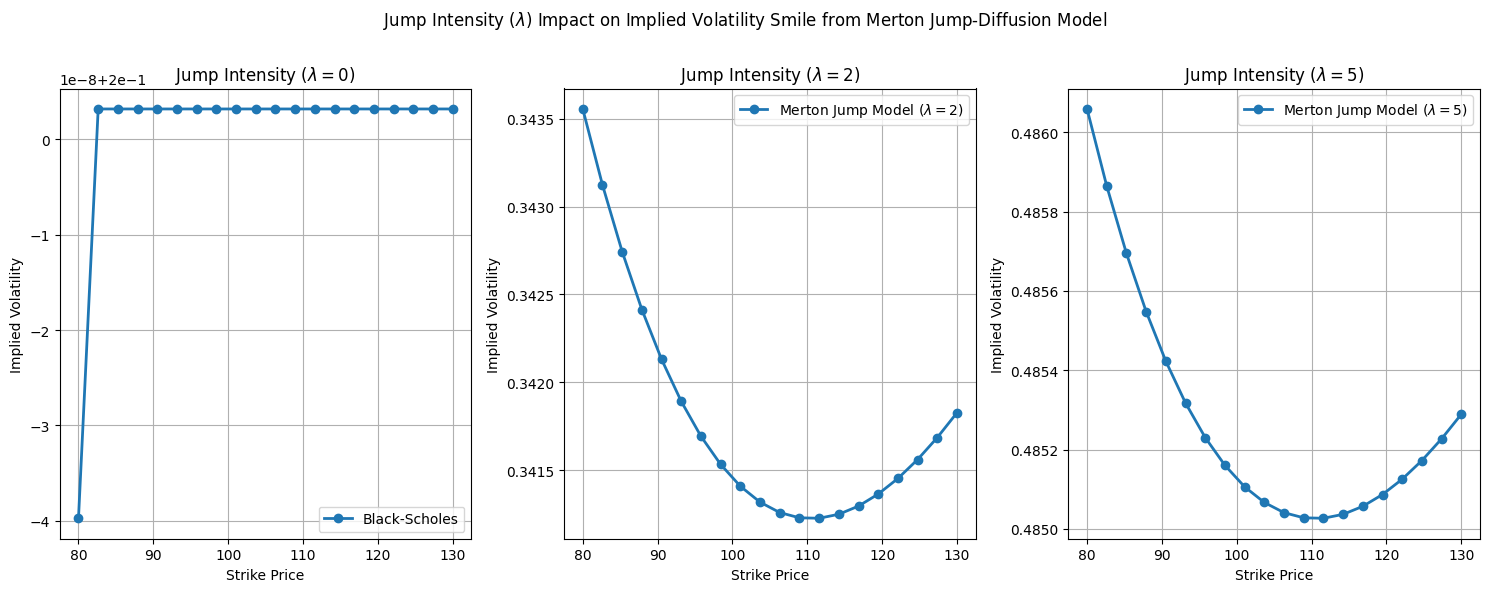

In [10]:
strikes = np.linspace(80, 130, 20)
lambda_test = [0, 2, 5]

plt.figure(figsize=(15, 6))


for i in range(len(lambda_test)):
    implied_vols = []
    for K_i in strikes:
        price_i, _ = merton_jump_price(S0, K_i, T, r, sigma, lambda_test[i], mu_J, sigma_J)
        iv = implied_volatility_dichotomy(price_i, S0, K_i, T, r)
        implied_vols.append(iv)

    plt.subplot(1, 3, i + 1)
    label = 'Black-Scholes' if lambda_test[i] == 0 else f'Merton Jump Model ($\lambda={lambda_test[i]}$)'
    plt.plot(strikes, implied_vols, marker='o', linewidth=2, label=label)
    plt.xlabel('Strike Price')
    plt.ylabel('Implied Volatility')
    plt.legend()
    plt.grid(True)
    plt.title(f"Jump Intensity ($\lambda={lambda_test[i]}$)")

plt.suptitle('Jump Intensity ($\lambda$) Impact on Implied Volatility Smile from Merton Jump-Diffusion Model')
plt.tight_layout()
plt.show()

En comparant l'effet de l'intensité des sauts ($\lambda$) sur le smile de volatilité implicite, on constate que des valeurs plus élevées de $\lambda$ amplifient le smile. En effet, une intensité de saut plus élevée signifie que les sauts se produisent plus fréquemment, ce qui augmente la probabilité d'événements extrêmes affectant le prix de l'actif sous-jacent. Cela conduit à une volatilité implicite plus élevée pour les options deep in-the-money et out-of-the-money, renforçant ainsi le smile observé. En revanche, lorsque $\lambda = 0$, le modèle revient au modèle de Black-Scholes classique, qui ne génère pas de smile de volatilité implicite.